In [ ]:
import gym
import d4rl
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

ENV_NAME = 'kitchen-complete-v0'
env = gym.make(ENV_NAME)
render = lambda : plt.imshow(env.render(mode='rgb_array'))


In [ ]:
print(env.reset())
render()

In [ ]:
action = env.action_space.sample()
print(action)
print(env.step(action))
render()

In [ ]:
# DDPG implementation
from copy import deepcopy
import numpy as np
import torch
from torch.optim import Adam
import gym
import time


import numpy as np
import scipy.signal

import torch
import torch.nn as nn
from tqdm.notebook import tqdm


def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)

def mlp(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

def count_vars(module):
    return sum([np.prod(p.shape) for p in module.parameters()])

class MLPActor(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation, act_limit):
        super().__init__()
        pi_sizes = [obs_dim] + list(hidden_sizes) + [act_dim]
        self.pi = mlp(pi_sizes, activation, nn.Tanh)
        self.act_limit = act_limit

    def forward(self, obs):
        # Return output from network scaled to action space limits.
        return self.act_limit * self.pi(obs)

class MLPQFunction(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        self.q = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, obs, act):
        q = self.q(torch.cat([obs, act], dim=-1))
        return torch.squeeze(q, -1) # Critical to ensure q has right shape.

class MLPActorCritic(nn.Module):

    def __init__(self, observation_space, action_space, hidden_sizes=(256,256),
                 activation=nn.ReLU):
        super().__init__()

        obs_dim = observation_space.shape[0]
        act_dim = action_space.shape[0]
        act_limit = action_space.high[0]

        # build policy and value functions
        self.pi = MLPActor(obs_dim, act_dim, hidden_sizes, activation, act_limit)
        self.q = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation)

    def act(self, obs):
        with torch.no_grad():
            return self.pi(obs).numpy()




class ReplayBuffer:
    """
    A simple FIFO experience replay buffer for DDPG agents.
    """

    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in batch.items()}



def ddpg(env_fn, actor_critic=MLPActorCritic, ac_kwargs=dict(), seed=0, 
         steps_per_epoch=1000, epochs=100, replay_size=int(1e6), gamma=0.99, 
         polyak=0.995, pi_lr=1e-3, q_lr=1e-3, batch_size=100, start_steps=10000, 
         update_after=1000, update_every=50, act_noise=0.1, num_test_episodes=10, 
         max_ep_len=1000, logger_kwargs=dict(), save_freq=1):
    """
    Deep Deterministic Policy Gradient (DDPG)
    Args:
        env_fn : A function which creates a copy of the environment.
            The environment must satisfy the OpenAI Gym API.
        actor_critic: The constructor method for a PyTorch Module with an ``act`` 
            method, a ``pi`` module, and a ``q`` module. The ``act`` method and
            ``pi`` module should accept batches of observations as inputs,
            and ``q`` should accept a batch of observations and a batch of 
            actions as inputs. When called, these should return:
            ===========  ================  ======================================
            Call         Output Shape      Description
            ===========  ================  ======================================
            ``act``      (batch, act_dim)  | Numpy array of actions for each 
                                           | observation.
            ``pi``       (batch, act_dim)  | Tensor containing actions from policy
                                           | given observations.
            ``q``        (batch,)          | Tensor containing the current estimate
                                           | of Q* for the provided observations
                                           | and actions. (Critical: make sure to
                                           | flatten this!)
            ===========  ================  ======================================
        ac_kwargs (dict): Any kwargs appropriate for the ActorCritic object 
            you provided to DDPG.
        seed (int): Seed for random number generators.
        steps_per_epoch (int): Number of steps of interaction (state-action pairs) 
            for the agent and the environment in each epoch.
        epochs (int): Number of epochs to run and train agent.
        replay_size (int): Maximum length of replay buffer.
        gamma (float): Discount factor. (Always between 0 and 1.)
        polyak (float): Interpolation factor in polyak averaging for target 
            networks. Target networks are updated towards main networks 
            according to:
            .. math:: \\theta_{\\text{targ}} \\leftarrow 
                \\rho \\theta_{\\text{targ}} + (1-\\rho) \\theta
            where :math:`\\rho` is polyak. (Always between 0 and 1, usually 
            close to 1.)
        pi_lr (float): Learning rate for policy.
        q_lr (float): Learning rate for Q-networks.
        batch_size (int): Minibatch size for SGD.
        start_steps (int): Number of steps for uniform-random action selection,
            before running real policy. Helps exploration.
        update_after (int): Number of env interactions to collect before
            starting to do gradient descent updates. Ensures replay buffer
            is full enough for useful updates.
        update_every (int): Number of env interactions that should elapse
            between gradient descent updates. Note: Regardless of how long 
            you wait between updates, the ratio of env steps to gradient steps 
            is locked to 1.
        act_noise (float): Stddev for Gaussian exploration noise added to 
            policy at training time. (At test time, no noise is added.)
        num_test_episodes (int): Number of episodes to test the deterministic
            policy at the end of each epoch.
        max_ep_len (int): Maximum length of trajectory / episode / rollout.
        save_freq (int): How often (in terms of gap between epochs) to save
            the current policy and value function.
    """


    torch.manual_seed(seed)
    np.random.seed(seed)

    env, test_env = env_fn(), env_fn()
    obs_dim = env.observation_space.shape
    act_dim = env.action_space.shape[0]

    # Action limit for clamping: critically, assumes all dimensions share the same bound!
    act_limit = env.action_space.high[0]

    # Create actor-critic module and target networks
    ac = actor_critic(env.observation_space, env.action_space, **ac_kwargs)
    ac_targ = deepcopy(ac)

    # Freeze target networks with respect to optimizers (only update via polyak averaging)
    for p in ac_targ.parameters():
        p.requires_grad = False

    # Experience buffer
    replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=replay_size)

    # Count variables (protip: try to get a feel for how different size networks behave!)
    var_counts = tuple(count_vars(module) for module in [ac.pi, ac.q])
    print('\nNumber of parameters: \t pi: %d, \t q: %d\n'%var_counts)

    # Set up function for computing DDPG Q-loss
    def compute_loss_q(data):
        o, a, r, o2, d = data['obs'], data['act'], data['rew'], data['obs2'], data['done']

        q = ac.q(o,a)

        # Bellman backup for Q function
        with torch.no_grad():
            q_pi_targ = ac_targ.q(o2, ac_targ.pi(o2))
            backup = r + gamma * (1 - d) * q_pi_targ

        # MSE loss against Bellman backup
        loss_q = ((q - backup)**2).mean()

        # Useful info for logging
        loss_info = dict(QVals=q.detach().numpy())

        return loss_q, loss_info

    # Set up function for computing DDPG pi loss
    def compute_loss_pi(data):
        o = data['obs']
        q_pi = ac.q(o, ac.pi(o))
        return -q_pi.mean()

    # Set up optimizers for policy and q-function
    pi_optimizer = Adam(ac.pi.parameters(), lr=pi_lr)
    q_optimizer = Adam(ac.q.parameters(), lr=q_lr)


    def update(data):
        # First run one gradient descent step for Q.
        q_optimizer.zero_grad()
        loss_q, loss_info = compute_loss_q(data)
        loss_q.backward()
        q_optimizer.step()

        # Freeze Q-network so you don't waste computational effort 
        # computing gradients for it during the policy learning step.
        for p in ac.q.parameters():
            p.requires_grad = False

        # Next run one gradient descent step for pi.
        pi_optimizer.zero_grad()
        loss_pi = compute_loss_pi(data)
        loss_pi.backward()
        pi_optimizer.step()

        # Unfreeze Q-network so you can optimize it at next DDPG step.
        for p in ac.q.parameters():
            p.requires_grad = True

        # Record things
        tqdm.write(f"Loss Q {loss_q.item()}, LossPi={loss_pi.item()}")

        # Finally, update target networks by polyak averaging.
        with torch.no_grad():
            for p, p_targ in zip(ac.parameters(), ac_targ.parameters()):
                # NB: We use an in-place operations "mul_", "add_" to update target
                # params, as opposed to "mul" and "add", which would make new tensors.
                p_targ.data.mul_(polyak)
                p_targ.data.add_((1 - polyak) * p.data)

    def get_action(o, noise_scale):
        a = ac.act(torch.as_tensor(o, dtype=torch.float32))
        a += noise_scale * np.random.randn(act_dim)
        return np.clip(a, -act_limit, act_limit)

    def test_agent():
        for j in range(num_test_episodes):
            o, d, ep_ret, ep_len = test_env.reset(), False, 0, 0
            while not(d or (ep_len == max_ep_len)):
                # Take deterministic actions at test time (noise_scale=0)
                o, r, d, _ = test_env.step(get_action(o, 0))
                ep_ret += r
                ep_len += 1

    # Prepare for interaction with environment
    total_steps = steps_per_epoch * epochs
    start_time = time.time()
    o, ep_ret, ep_len = env.reset(), 0, 0

    # Main loop: collect experience in env and update/log each epoch
    for t in tqdm(range(total_steps)):
        
        # Until start_steps have elapsed, randomly sample actions
        # from a uniform distribution for better exploration. Afterwards, 
        # use the learned policy (with some noise, via act_noise). 
        if t > start_steps:
            a = get_action(o, act_noise)
        else:
            a = env.action_space.sample()

        # Step the env
        o2, r, d, _ = env.step(a)
        ep_ret += r
        ep_len += 1

        # Ignore the "done" signal if it comes from hitting the time
        # horizon (that is, when it's an artificial terminal signal
        # that isn't based on the agent's state)
        d = False if ep_len==max_ep_len else d

        # Store experience to replay buffer
        replay_buffer.store(o, a, r, o2, d)

        # Super critical, easy to overlook step: make sure to update 
        # most recent observation!
        o = o2

        # End of trajectory handling
        if d or (ep_len == max_ep_len):
            o, ep_ret, ep_len = env.reset(), 0, 0

        # Update handling
        if t >= update_after and t % update_every == 0:
            for _ in range(update_every):
                batch = replay_buffer.sample_batch(batch_size)
                update(data=batch)

        # End of epoch handling
        if (t+1) % steps_per_epoch == 0:
            epoch = (t+1) // steps_per_epoch

            # Save model
            if (epoch % save_freq == 0) or (epoch == epochs):
                pass

            # Test the performance of the deterministic version of the agent.
            test_agent()

            # Log info about epoch
            tqdm.write(f"Epoch {epoch}")
            tqdm.write(f"Time, {time.time()-start_time}")
    return ac

if __name__ == '__main__':

    HIDDEN_SIZE = 256
    GAMMA = 0.99
    SEED = 0
    EPOCHS = 100
    NUM_LAYERS = 2

    policy = ddpg(lambda : gym.make(ENV_NAME), actor_critic=MLPActorCritic,
         ac_kwargs=dict(hidden_sizes=[HIDDEN_SIZE]*NUM_LAYERS), 
         gamma=GAMMA, seed=SEED, epochs=EPOCHS)

In [ ]:
env = gym.make(ENV_NAME)
observation = env.reset()

In [ ]:
action = policy.act(torch.as_tensor(observation, dtype=torch.float32))
print(action)
observation,*_ = env.step(action)
print(observation)
render()


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import time 


# initialize an empty figure
fig, ax = plt.subplots()

# initialize empty lists to store x and y values
x_vals = []
loss_a_vals = []
loss_b_vals = []

# plot line for loss A, with empty marker to show only the line
loss_a_line, = ax.plot(x_vals, loss_a_vals, '-o', label='Loss A', color='blue', markerfacecolor='none')

# plot line for loss B, with empty marker to show only the line
loss_b_line, = ax.plot(x_vals, loss_b_vals, '-o', label='Loss B', color='red', markerfacecolor='none')

# add legend to the plot
ax.legend()

# set x and y axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss value')

# set the title of the plot
ax.set_title('Loss A and B over epochs')

# function to update the plot with new values
def update_plot(epoch, loss_a, loss_b):
    # append new values to the lists
    x_vals.append(epoch)
    loss_a_vals.append(loss_a)
    loss_b_vals.append(loss_b)
    
    # update data for the two lines
    loss_a_line.set_data(x_vals, loss_a_vals)
    loss_b_line.set_data(x_vals, loss_b_vals)
    
    # set new x and y limits for the plot
    ax.set_xlim([min(x_vals) - 1, max(x_vals) + 1])
    ax.set_ylim([min(loss_a_vals + loss_b_vals) - 0.1, max(loss_a_vals + loss_b_vals) + 0.1])
    
    # redraw the plot with the updated data
    fig.canvas.draw()

# example usage of the update_plot function
update_plot(1, 0.5, 0.6)
update_plot(2, 0.4, 0.5)
update_plot(3, 0.3, 0.4)


In [ ]:
import optuna
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

# Define the PyTorch model
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return Categorical(logits=x)
        
# Define the training function
def train(env, policy, optimizer, num_steps):
    rewards = []
    obs = env.reset()
    for i in range(num_steps):
        action = policy(torch.from_numpy(obs).float())
        action = action.sample().numpy()
        obs, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            break
    
    # Compute the loss and perform backpropagation
    returns = np.zeros_like(rewards)
    running_return = 0
    for i in reversed(range(len(rewards))):
        running_return = rewards[i] + running_return * 0.99
        returns[i] = running_return
    returns = torch.tensor(returns)
    log_probs = policy(torch.from_numpy(obs).float()).log_prob(torch.from_numpy(action))
    loss = -(log_probs * returns).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return np.sum(rewards)

# Define the objective function to optimize with Optuna
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-1)
    num_steps = trial.suggest_int("num_steps", 100, 1000)
    env = gym.make('CartPole-v1')
    policy = Policy()
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    
    rewards = []
    for i in range(10):
        total_reward = train(env, policy, optimizer, num_steps)
        rewards.append(total_reward)
    

    return np.mean(rewards)

# Create the Optuna study and run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print the best hyperparameters found by Optuna
print("Best hyperparameters found: ", study.best_params)
print("Best reward found: ", study.best_value)
print("Best trial: ", study.best_trial)

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_slice(study)
optuna.visualization.matplotlib.plot_parallel_coordinate(study)
optuna.visualization.matplotlib.plot_contour(study)
optuna.visualization.matplotlib.plot_intermediate_values(study)
optuna.visualization.matplotlib.plot_edf(study)
optuna.visualization.matplotlib.plot_param_importances(study)

In [ ]:
import torch

N = 10
NUM_SAMPLE = 100
CONSTANT_NOISE = torch.rand(NUM_SAMPLE, 10)


def _get_noised_obs(self, obs, actions, eps):
    M, N, A = obs.shape[0], obs.shape[1], actions.shape[1]
    size = 100
    delta_s = 2 * eps * self.obs_std * (CONSTANT_NOISE - 0.5) 
    tmp_obs = obs.reshape(-1, 1, N).repeat(1, size, 1).reshape(-1, N)
    delta_s = delta_s.reshape(1, size, N).repeat(M, 1, 1).reshape(-1, N)
    noised_obs = tmp_obs + delta_s
    return M, A, size, noised_obs, delta_s


def _get_noised_obs_plus(self, obs, actions, eps):
    M, N, A = obs.shape[0], obs.shape[1], actions.shape[1]
    size = self.num_samples
    delta_s = 2 * eps * self.obs_std * (CONSTANT_NOISE - 0.5) 
    tmp_obs = obs.reshape(-1, 1, N).repeat(1, size, 1).reshape(-1, N)
    delta_s = delta_s.reshape(1, size, N).repeat(M, 1, 1).reshape(-1, N)
    noised_obs = tmp_obs + delta_s
    return M, A, size, noised_obs, delta_s



# Test the function with example inputs
obs = torch.randn(3, 7)  # Example observation tensor
actions = torch.randn(3, 2)  # Example actions tensor
eps = 0.1  # Example epsilon value
result1 = _get_noised_obs(obs, actions, eps)
result2 = _get_noised_obs_plus(obs, actions, eps)

print (torch.mean((result1[3]-result2[3])**2))

In [17]:
import torch
num_qs = 10
B = 3

q_target = torch.randn(3, 1).requires_grad_()
q_target_detach1 = q_target.detach().unsqueeze(0).repeat(num_qs, 1, 1) 



q_target_detach = q_target.unsqueeze(0).detach()
# Use `expand` instead of `repeat` to avoid copying data
q_target_detach = q_target_detach.expand(num_qs, -1, -1)


# print(q_target_detach1-q_target_detach)
# print(q_target_detach)

obs = torch.tensor([[1,2,3],[4,5,6],[7,8,9],[10,11,12]],dtype=torch.float)
print(obs)
print(obs.unsqueeze(1).expand(-1, 2, -1).contiguous())
obs1 = obs.repeat_interleave(2, dim=0)
print(obs1)

tensor([[ 1.,  2.,  3.],
        [ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [10., 11., 12.]])
tensor([[[ 1.,  2.,  3.],
         [ 1.,  2.,  3.]],

        [[ 4.,  5.,  6.],
         [ 4.,  5.,  6.]],

        [[ 7.,  8.,  9.],
         [ 7.,  8.,  9.]],

        [[10., 11., 12.],
         [10., 11., 12.]]])
tensor([[ 1.,  2.,  3.],
        [ 1.,  2.,  3.],
        [ 4.,  5.,  6.],
        [ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [ 7.,  8.,  9.],
        [10., 11., 12.],
        [10., 11., 12.]])


In [ ]:
class SACTrainerRank1(TorchTrainer):
    """
    Soft Actor Critic (Haarnoja et al. 2018). (Offline training ver.)
    Continuous maximum Q-learning algorithm with parameterized actor.
    """
    def __init__(
            self,
            env,  # Associated environment for learning
            policy,  # Associated policy (should be TanhGaussian)
            qfs,  # Q functions
            target_qfs,  # Slow updater to Q functions
            discount=0.99,  # Discount factor
            reward_scale=1.0,  # Scaling of rewards to modulate entropy bonus
            use_automatic_entropy_tuning=True,  # Whether to use the entropy-constrained variant
            target_entropy=None,  # Target entropy for entropy-constraint variant
            policy_lr=3e-4,  # Learning rate of policy and entropy weight
            qf_lr=3e-4,  # Learning rate of Q functions
            optimizer_class=optim.Adam,  # Class of optimizer for all networks
            soft_target_tau=5e-3,  # Rate of update of target networks
            target_update_period=1,  # How often to update target networks
            max_q_backup=False,
            deterministic_backup=False,
            policy_eval_start=0,
            eta=-1.0,
            num_qs=10,
            replay_buffer=None,
            imagination=None,

            # smoothing
            num_samples=20,
            policy_smooth_eps=0,
            policy_smooth_reg=0.0,
            q_smooth_eps=0,
            q_smooth_reg=0.0,
            q_smooth_tau=0.2,
            norm_input=False,
            obs_std=1,
            q_ood_eps=0,
            q_ood_reg = 0,
            q_ood_uncertainty_reg=0,
            q_ood_uncertainty_reg_min=0,
            q_ood_uncertainty_decay=1e-6,
    ):
        super().__init__()

        self.env = env
        self.policy = policy
        self.qfs = qfs
        self.target_qfs = target_qfs
        self.target_qfs.eval()
        for param in target_qfs.parameters():
            param.requires_grad = False

        self.num_qs = num_qs

        self.discount = discount
        self.reward_scale = reward_scale
        self.soft_target_tau = soft_target_tau
        self.target_update_period = target_update_period

        self.max_q_backup = max_q_backup
        self.deterministic_backup = deterministic_backup
        self.eta = eta
        self.replay_buffer = replay_buffer

        #### robust 
        self.num_samples = num_samples
        self.policy_smooth_eps = policy_smooth_eps
        self.policy_smooth_reg = policy_smooth_reg
        self.q_smooth_eps = q_smooth_eps
        self.q_smooth_reg = q_smooth_reg
        self.q_smooth_tau = q_smooth_tau
        self.obs_std = 1 if not norm_input else ptu.from_numpy(obs_std)
        self.q_ood_eps = q_ood_eps
        self.q_ood_reg = q_ood_reg
        self.q_ood_uncertainty_reg = q_ood_uncertainty_reg
        self.q_ood_uncertainty_reg_min = q_ood_uncertainty_reg_min
        self.q_ood_uncertainty_decay = q_ood_uncertainty_decay

        self.use_automatic_entropy_tuning = use_automatic_entropy_tuning
        if self.use_automatic_entropy_tuning:
            if target_entropy:
                self.target_entropy = target_entropy
            else:
                # Heuristic value: dimension of action space
                self.target_entropy = -np.prod(
                    self.env.action_space.shape).item()
            self.log_alpha = ptu.zeros(1, requires_grad=True)
            self.alpha_optimizer = optimizer_class(
                [self.log_alpha],
                lr=policy_lr,
            )

        self.qf_criterion = nn.MSELoss(reduction='none')

        self.policy_optimizer = optimizer_class(
            self.policy.parameters(),
            lr=policy_lr,
        )
        # Add weight decay
        self.qfs_optimizer = optimizer_class(
            self.qfs.parameters(),
            lr=qf_lr,
            weight_decay=1e-4,
        ) 

        self.eval_statistics = OrderedDict()
        self._need_to_update_eval_statistics = True
        self.policy_eval_start = policy_eval_start

    def _get_tensor_values(self, obs, actions, network=None):
        action_shape = actions.shape[0]
        B,E = obs.shape
        num_repeat = action_shape // B
        preds = network(obs.unsqueeze(1).expand(-1,num_repeat,-1).contiguous().view(-1,E), actions)
        # preds size (ensembles, B*Num_repeat,E) => (ensembles, B, Num_repeat, E)
        preds = preds.view(-1, B, num_repeat, 1)
        return preds

    def _get_policy_actions(self, obs, num_actions, network=None):
        new_obs_actions, _, _, new_obs_log_pi, *_ = network(
            obs.unsqueeze(1).expand(-1, num_actions,-1).contiguous().view(-1,obs.shape[1]),
            reparameterize=True,
            return_log_prob=True,
        )
        return new_obs_actions.detach(), new_obs_log_pi.view(
            obs.shape[0], num_actions, 1).detach()
        

    def _get_noised_obs(self, obs, actions, eps):
        """ Add noise to observations 
            Each observation is repeated interleave num_samples times
        """
        M, N = obs.shape[0], obs.shape[1] 
        A = actions.shape[1]
        size = self.num_samples
        delta_s = 2 * eps * self.obs_std * (torch.rand(size, N, device=ptu.device) - 0.5) 
        tmp_obs = obs.unsqueeze(1).expand(-1, size, -1).contiguous()  
        noised_obs = tmp_obs + delta_s
        return M, A, size, noised_obs.view(-1,N)


    def train_from_torch(self, batch, indices):
        obs= batch['observations']
        next_obs = batch['next_observations']
        actions = batch['actions']
        rewards = batch['rewards']
        terminals = batch['terminals']
        
        if self.eta > 0:
            actions.requires_grad_(True)
        
        """
        Policy and Alpha Loss
        """
        # (B,A)= (256,6)             
        new_obs_actions, policy_mean, policy_log_std, log_pi, *_ = self.policy(
            obs,
            reparameterize=True,
            return_log_prob=True,
        )

        if self.use_automatic_entropy_tuning:
            alpha_loss = -(self.log_alpha *
                           (log_pi + self.target_entropy).detach()).mean()
            alpha = self.log_alpha.exp()
        else:
            alpha_loss = 0
            alpha = 1
        # (B,1)
        q_new_actions = self.qfs.sample(obs, new_obs_actions)  # TODO: Consider to detach Q value

        policy_loss = (alpha * log_pi - q_new_actions).mean()

        if self._num_train_steps < self.policy_eval_start:
            """
            For the initial few epochs, try doing behaivoral cloning, if needed
            conventionally, there's not much difference in performance with having 20k 
            gradient steps here, or not having it
            """
            policy_log_prob = self.policy.get_log_probs(obs.detach(), actions)
            policy_loss = (alpha * log_pi - policy_log_prob).mean()

        
        if self.policy_smooth_eps > 0 and self.policy_smooth_reg > 0:
            M, A, size, noised_obs = self._get_noised_obs(obs, actions, self.policy_smooth_eps)
            # (B*size,A)
            _, noised_policy_mean, noised_policy_log_std, _, *_ = self.policy(noised_obs,reparameterize=True)
            # action_dist = torch.distributions.Normal(policy_mean.repeat_interleave(size, dim=0),
            #                                         policy_log_std.exp().repeat_interleave(size, dim=0))
            action_dist = torch.distributions.Normal(policy_mean.unsqueeze(1).expand(-1,size,-1).contiguous().view(-1,A),
                                                    policy_log_std.exp().unsqueeze(1).expand(-1,size,-1).contiguous().view(-1,A))                                      
            noised_action_dist = torch.distributions.Normal(noised_policy_mean, noised_policy_log_std.exp())
            kl_loss = kl_divergence(action_dist, noised_action_dist).sum(axis=-1) + kl_divergence(noised_action_dist, action_dist).sum(axis=-1)
            kl_loss = kl_loss.view(M, size)
            max_values, _ = torch.max(kl_loss, dim=1)
            kl_loss_max = torch.mean(max_values)



            # noised_states_selected = noised_obs[np.arange(M), max_id]
            policy_loss += self.policy_smooth_reg * kl_loss_max
            if self._need_to_update_eval_statistics:
                self.eval_statistics['Policy Smooth Loss'] = ptu.get_numpy(kl_loss_max) * self.policy_smooth_reg

        """
        QF Loss
        """
        # (num_qs, batch_size, output_size) (M,B,1)
        qs_pred = self.qfs(obs, actions)

        new_next_actions, _, _, new_log_pi, *_ = self.policy(
            next_obs,
            reparameterize=False,
            return_log_prob=True,
        )

        if not self.max_q_backup:
            with torch.no_grad():
                target_q_values = self.target_qfs.sample(next_obs, new_next_actions)
                if not self.deterministic_backup:
                    target_q_values -= alpha * new_log_pi
        else:
            # if self.max_q_backup
            next_actions_temp, _ = self._get_policy_actions(
                next_obs, num_actions=10, network=self.policy)
            target_q_values = self._get_tensor_values(
                next_obs, next_actions_temp,
                network=self.qfs).max(2)[0].min(0)[0]

        future_values = (1. - terminals) * self.discount * target_q_values
        q_target = self.reward_scale * rewards + future_values

        q_target_detach = q_target.unsqueeze(0)
        # Use `expand` instead of `repeat` to avoid copying data
        q_target_detach = q_target_detach.expand(self.num_qs, -1, -1).contiguous()
        qfs_loss = self.qf_criterion(qs_pred, q_target_detach)
        qfs_loss = qfs_loss.mean(dim=(1, 2)).sum()
        qfs_loss_total = qfs_loss
        if self.q_smooth_eps > 0 and self.q_smooth_reg > 0:
            M, A, size, noised_obs = self._get_noised_obs(obs, actions, self.q_smooth_eps)
            # (M,B*size,1)
            noised_qs_pred = self.qfs(noised_obs, actions.unsqueeze(1).expand(-1,size,-1).contiguous().view(-1,A))
            diff = noised_qs_pred - qs_pred.expand(-1, -1, size).contiguous().view(self.num_qs, -1, 1)     
            pos = torch.clamp(diff, min=0)
            neg = torch.clamp(diff, max=0)
            noise_Q_loss = (1-self.q_smooth_tau) *  pos.square().mean(axis=0) + self.q_smooth_tau * neg.square().mean(axis=0)
            noise_Q_loss = noise_Q_loss.view(M, size)
            noise_Q_loss_max = torch.mean(torch.max(noise_Q_loss,dim=1)[0])  
            qfs_loss_total += self.q_smooth_reg * noise_Q_loss_max
            if self._need_to_update_eval_statistics:
                self.eval_statistics['Q Smooth Loss'] = ptu.get_numpy(noise_Q_loss_max) * self.q_smooth_reg
                
        if self.q_ood_reg > 0: # self.q_ood_eps = 0 for PBRL
            ood_loss = torch.zeros(1, device=ptu.device)[0]
            if self.q_ood_uncertainty_reg > 0:
                M, A, size, noised_obs = self._get_noised_obs(obs, actions, self.q_ood_eps)
                ood_actions, _, _, _, *_ = self.policy(noised_obs, reparameterize=False)
                ood_qs_pred = self.qfs(noised_obs, ood_actions)
                ood_target = ood_qs_pred - self.q_ood_uncertainty_reg * ood_qs_pred.std(axis=0)
                ood_loss = self.qf_criterion(ood_target.detach(), ood_qs_pred).mean()
                qfs_loss_total += self.q_ood_reg * ood_loss

            if self.q_ood_uncertainty_reg > 0:
                self.q_ood_uncertainty_reg = max(self.q_ood_uncertainty_reg - self.q_ood_uncertainty_decay, self.q_ood_uncertainty_reg_min)
            if self._need_to_update_eval_statistics:
                self.eval_statistics['Q OOD Loss'] = ptu.get_numpy(ood_loss) * self.q_ood_reg
                self.eval_statistics['q_ood_uncertainty_reg'] = self.q_ood_uncertainty_reg
        
        if self.eta > 0:
            qs_pred_grads = None
            sample_size = min(qs_pred.size(0), actions.size(1))
            indices = np.random.choice(qs_pred.size(0), size=sample_size, replace=False)
            indices = torch.from_numpy(indices).long().to(ptu.device)

            obs_tile = obs.unsqueeze(0).expand(self.num_qs, -1, -1).contiguous()
            actions_tile = actions.unsqueeze(0).expand(self.num_qs, -1, -1).contiguous().requires_grad_(True)
            qs_preds_tile = self.qfs(obs_tile, actions_tile)
            qs_pred_grads, = torch.autograd.grad(qs_preds_tile.sum(), actions_tile, retain_graph=True, create_graph=True)
            qs_pred_grads = qs_pred_grads / (torch.norm(qs_pred_grads, p=2, dim=2).unsqueeze(-1) + 1e-10)

            qs_pred_grads = torch.index_select(qs_pred_grads, dim=0, index=indices).transpose(0, 1)
            
            qs_pred_grads = torch.einsum('bik,bjk->bij', qs_pred_grads, qs_pred_grads)
            masks = torch.eye(sample_size, device=ptu.device).unsqueeze(dim=0).expand(qs_pred_grads.size(0), -1, -1).contiguous()
            qs_pred_grads = (1 - masks) * qs_pred_grads
            grad_loss = torch.mean(torch.sum(qs_pred_grads, dim=(1, 2))) / (sample_size - 1)
            
            qfs_loss_total += self.eta * grad_loss

        if self.use_automatic_entropy_tuning and not self.deterministic_backup:
            self.alpha_optimizer.zero_grad()
            alpha_loss.backward()
            self.alpha_optimizer.step()

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        self.qfs_optimizer.zero_grad()
        qfs_loss_total.backward()
        self.qfs_optimizer.step()

        self.try_update_target_networks()
        """
        Save some statistics for eval
        """
        if self._need_to_update_eval_statistics:
            self._need_to_update_eval_statistics = False

            policy_loss = ptu.get_numpy(log_pi - q_new_actions).mean()
            policy_avg_std = ptu.get_numpy(torch.exp(policy_log_std)).mean()
            self.eval_statistics['QFs Loss'] = np.mean(
                ptu.get_numpy(qfs_loss)) / self.num_qs
            if self.eta > 0:
                self.eval_statistics['Q Grad Loss'] = np.mean(
                    ptu.get_numpy(grad_loss))
            self.eval_statistics['Policy Loss'] = np.mean(policy_loss)

            self.eval_statistics.update(
                create_stats_ordered_dict(
                    'Qs Predictions',
                    ptu.get_numpy(qs_pred),
                ))
            self.eval_statistics.update(
                create_stats_ordered_dict(
                    'Qs Targets',
                    ptu.get_numpy(q_target),
                ))

            self.eval_statistics.update(
                create_stats_ordered_dict(
                    'Log Pis',
                    ptu.get_numpy(log_pi),
                ))
            self.eval_statistics.update(
                create_stats_ordered_dict(
                    'Policy mu',
                    ptu.get_numpy(policy_mean),
                ))
            self.eval_statistics.update(
                create_stats_ordered_dict(
                    'Policy log std',
                    ptu.get_numpy(policy_log_std),
                ))
            self.eval_statistics['Policy std'] = np.mean(policy_avg_std)

            if self.use_automatic_entropy_tuning:
                self.eval_statistics['Alpha'] = alpha.item()
                self.eval_statistics['Alpha Loss'] = alpha_loss.item()

    def try_update_target_networks(self):
        if self._num_train_steps % self.target_update_period == 0:
            self.update_target_networks()

    def update_target_networks(self):
        ptu.soft_update_from_to(self.qfs, self.target_qfs,
                                self.soft_target_tau)

    def get_diagnostics(self):
        return self.eval_statistics

    def end_epoch(self, epoch):
        self._need_to_update_eval_statistics = True

    @property
    def networks(self):
        base_list = [
            self.policy,
            self.qfs,
            self.target_qfs,
        ]

        return base_list

    def get_snapshot(self):
        return dict(
            policy=self.policy,
            qfs=self.qfs,
            target_qfs=self.qfs,
            log_alpha=self.log_alpha,
            policy_optim=self.policy_optimizer,
            qfs_optim=self.qfs_optimizer,
            alpha_optim=self.alpha_optimizer,
        )
    
    def load_snapshot(self, path):
        datas = torch.load(path, map_location=ptu.device)
        self.policy.load_state_dict(datas['trainer/policy'].state_dict())
        self.qfs.load_state_dict(datas['trainer/qfs'].state_dict())
        self.target_qfs.load_state_dict(datas['trainer/target_qfs'].state_dict())
        self.log_alpha = datas['trainer/log_alpha']
        self.policy_optimizer.load_state_dict( datas['trainer/policy_optim'].state_dict())
        self.qfs_optimizer.load_state_dict(datas['trainer/qfs_optim'].state_dict())
        self.alpha_optimizer.load_state_dict(datas['trainer/alpha_optim'].state_dict())
        logger.log('Loading model from {} finished'.format(path))
    
    def load_qfs(self, path):
        datas = torch.load(path, map_location=ptu.device)
        self.qfs.load_state_dict(datas['trainer/qfs'].state_dict())
        logger.log('Loading Q networks from {} finished'.format(path))




In [123]:
import json



def simplify_dict(d):
    """
    Recursive helper function to simplify a nested dictionary.

    Args:
        d (dict): The input dictionary.

    Returns:
        dict: The simplified dictionary without any inner dictionaries.
    """
    return {k: v if not isinstance(v, dict) else simplify_dict(v) for k, v in d.items()}



json_str = {
  "algorithm": "",
  "collector_type": "step",
  "env_kwargs": {},
  "env_name": "hopper-medium-expert-v2",
  "eval_attack": False,
  "eval_attack_eps": 0.01,
  "eval_attack_mode": "random",
  "eval_no_training": False,
  "load_Qs": "",
  "load_path": "",
  "norm_input": True,
  "offline_kwargs": {
    "batch_size": 512,
    "max_path_length": 1000,
    "num_epochs": 500,
    "num_eval_steps_per_epoch": 1000,
    "num_trains_per_train_loop": 1000,
    "save_snapshot_freq": 500
  },
  "policy_kwargs": {
    "layer_size": 256,
    "num_p_layers": 3,
    "num_q_layers": 3
  },
  "replay_buffer_size": 2000000,
  "reward_mean": False,
  "reward_std": False,
  "seed": 0,
  "trainer_kwargs": {
    "deterministic_backup": False,
    "discount": 0.99,
    "eta": -1.0,
    "max_q_backup": False,
    "num_qs": 29,
    "num_samples": 20,
    "policy_eval_start": 0,
    "policy_lr": 0.007444261208897999,
    "policy_smooth_eps": 0.005,
    "policy_smooth_reg": 0.1,
    "q_ood_eps": 0.01,
    "q_ood_reg": 0.5,
    "q_ood_uncertainty_decay": 1e-06,
    "q_ood_uncertainty_reg": 3.0,
    "q_ood_uncertainty_reg_min": 1.0,
    "q_smooth_eps": 0.005,
    "q_smooth_reg": 0.0001,
    "q_smooth_tau": 0.2,
    "qf_lr": 0.0017850021952371426,
    "soft_target_tau": 0.005,
    "target_update_period": 1,
    "use_automatic_entropy_tuning": True
  }
}

# Get data from wandb and push back to wandb

In [59]:
import wandb
api = wandb.Api()
import pandas as pd



def get_data_from_run(name,entity="aimrl",project="MASTER_UNCERTAINTY"):
    '''Get the data from a wandb run. Data is only a sample of 500 data from the run.
    
    Returns: dataframe and config
    '''
    # name = 3pe2wl12"
    # run is specified by <entity>/<project>/<run_id>
    run = api.run(f"{entity}/{project}/{name}")

    # save the metrics for the run to a csv file
    metrics_dataframe = run.history()
    config = run.config
    run.wait_until_finished()


    headers = metrics_dataframe.columns.values.tolist()
    for key in headers:
        proc_key = key
        proc_key = proc_key.replace(' (s)', '')
        proc_key = proc_key.replace(' ', '_')
        proc_key = proc_key.lower()
        if '/' not in key or 'replay_buffer' in key:
            proc_key = 'misc/' + proc_key
        
        metrics_dataframe.rename(columns={key: proc_key}, inplace=True)

    
    headers = metrics_dataframe.columns.values.tolist()
    print(headers)

    # Loop through columns and convert values to float
    for col in metrics_dataframe:
        if col not in metrics_dataframe:  # Skip column names
            continue
        metrics_dataframe[col] = pd.to_numeric(metrics_dataframe[col], errors='coerce')
    return metrics_dataframe, config



In [102]:
def get_data_from_run_full(name,entity="aimrl",project="MASTER_UNCERTAINTY"):
    '''Return a list of dictionaries data for each step, and the config'''
    # name = 3pe2wl12"
    run = api.run(f"{entity}/{project}/{name}")

    data_dict_iterator = run.scan_history()
    config = run.config
    data_list = []
    for data_dict in data_dict_iterator:
        log_dict = {}
        for key in data_dict.keys():
            proc_key = key
            proc_key = proc_key.replace(' (s)', '')
            proc_key = proc_key.replace(' ', '_')
            proc_key = proc_key.lower()
            if '/' not in key or 'replay_buffer' in key:
                proc_key = 'misc/' + proc_key
            log_dict[proc_key] = float(data_dict[key])    
            
        data_list.append(log_dict)
    
    return data_list, config


def push_data_to_wandb(datalist,group="0",name="test",entity="aimrl",project="MASTER_UNCERTAINTY" , config=None):
    '''Push data to wandb. Data is a list of dictionaries. Each dictionary is a step.
    '''
    run = wandb.init(project=project, entity=entity, name=name, group=group,config=config)
    for i in range(len(datalist)):
        wandb.log(datalist[i])
    run.finish()


In [121]:
RUN_ID = "9sflu2rl" 
NEW_RUN_NAME = "walker2d-medium-replay-v2_RORL_BASELINE_SEED0"
GROUP="14"
datalist, config  = get_data_from_run_full(RUN_ID)
push_data_to_wandb(datalist,name= NEW_RUN_NAME,group=GROUP,config=config)

2023-04-17 20:50:29.460086: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 20:50:29.679793: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/mnt/hdd/thanh/.mujoco/mujoco210/bin:/usr/lib/nvidia
2023-04-17 20:50:29.679832: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-17 20:50:30.668113: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: 

evaluation/actions_mean,▁▃█▂▂▃▃▃▃▇▃▃▂▇▂▂▃▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂
evaluation/actions_std,▃▇▁▇██▇▇▇▂█▇█▃██████▇▇█▇█▇▇▇▇▇█▇▇▇▇▇▇███
evaluation/average_returns,▁▂▁▇▇▇▇▇▇▁▇▇▇▁▇▇▇▇▇█▇███████▇███████████
evaluation/num_paths,▆▆█▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
evaluation/num_paths_total,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
evaluation/num_steps_total,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
evaluation/path_length_mean,▂▂▁██████▁███▁██████████████████████████
evaluation/path_length_std,█▄▅▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
evaluation/returns_mean,▁▂▁▇▇▇▇▇▇▁▇▇▇▁▇▇▇▇▇█▇███████▇███████████
evaluation/returns_std,█▅▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
evaluation/rewards_mean,▂▅▁▇▇▇▇▇▇▁▇▇▇▁▇▇▇▇▇▇▇██████▇▇█▇▇███████▇


# Get data from tensorboard log and plot 

/mnt/hdd/thanh/workspace/2023/common/RORL/results/RORL_10/halfcheetah-medium-v2_Fri_Feb_24_16:50:21_2023_0
/mnt/hdd/thanh/workspace/2023/common/RORL/results/RORL_10/halfcheetah-medium-v2_Fri_Mar_10_23:19:29_2023_0


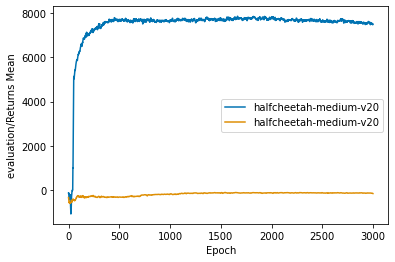

In [158]:
import os
import glob2
import csv
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

base_folder  ="/mnt/hdd/thanh/workspace/2023/common/RORL/results/RORL_10/"
file_progress = 'offline_progress.csv'
file_info = "variant.json"
SMOOTH_WINDOW = 3
X_AXIS = "Epoch"
Y_AXIS = "evaluation/Returns Mean"

color_palette = sns.color_palette("colorblind", 100)


def smooth(y, radius, mode='two_sided', valid_only=False):
    '''
    Copy from: https://github.com/openai/baselines/blob/master/baselines/common/plot_util.py
    Smooth signal y, where radius is determines the size of the window
    mode='twosided':
        average over the window [max(index - radius, 0), min(index + radius, len(y)-1)]
    mode='causal':
        average over the window [max(index - radius, 0), index]
    valid_only: put nan in entries where the full-sized window is not available
    '''
    assert mode in ('two_sided', 'causal')
    if len(y) < 2*radius+1:
        return np.ones_like(y) * y.mean()
    elif mode == 'two_sided':
        convkernel = np.ones(2 * radius+1)
        out = np.convolve(y, convkernel,mode='same') / np.convolve(np.ones_like(y), convkernel, mode='same')
        if valid_only:
            out[:radius] = out[-radius:] = np.nan
    elif mode == 'causal':
        convkernel = np.ones(radius)
        out = np.convolve(y, convkernel,mode='full') / np.convolve(np.ones_like(y), convkernel, mode='full')
        out = out[:-radius+1]
        if valid_only:
            out[:radius] = np.nan
    return out

child_paths = [os.path.abspath(os.path.join(path, '..'))
                   for path in glob2.glob(os.path.join(base_folder, '**', file_progress))]

for i,path in enumerate(child_paths):
    print(path)
    data_frame = pd.read_csv(os.path.join(path, file_progress))
    variant = json.load(open(os.path.join(path, file_info)))
    # draw the line plot of evaluation/Returns Mean vs. Epoch
    if SMOOTH_WINDOW is not None:
        plt.plot(data_frame[X_AXIS].to_numpy(dtype=float),smooth(data_frame[Y_AXIS].to_numpy(dtype=float),SMOOTH_WINDOW),label = variant['env_name']+str(variant['seed']),color=color_palette[i])
    else:
        plt.plot(data_frame[X_AXIS].to_numpy(dtype=float),data_frame[Y_AXIS].to_numpy(dtype=float),label = variant['env_name']+str(variant['seed']),color=color_palette[i])
    
plt.xlabel(X_AXIS)
plt.ylabel(Y_AXIS)
plt.legend()
plt.show()
# plt.savefig('MeanReturn.pdf', format='pdf',bbox_inches='tight')

